In [ ]:
import os
import pathlib
from datetime import datetime
import librosa
print(f'[INFO] Librosa: {librosa.__version__}')
import librosa.display as ld
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Audio
from tqdm import tqdm
import tensorflow as tf
print(f'[INFO] tensorflow: {tf.__version__}')
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import (TimeDistributed, Activation, LSTM, Dense, Dropout, Conv1D, Flatten, MaxPooling1D)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns

[INFO] Librosa: 0.8.1
[INFO] tensorflow: 2.9.2


#Emotion

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
emotions = [] # Emoção (01 = neutro, 02 = estresse(zangado, medo)).
full_path = []

def create_dataset_Geral(dataset):
  for root, dirs, files in tqdm(os.walk(dataset)):
    for file in files:
      try:
        if emotions.count(2) < 1700:
          if root == "/content/drive/MyDrive/Emotions/Neutral":
            label = 1
          else:
            label = 2
          emotions.append(label)
          full_path.append((root, file))
      except ValueError:
        continue

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
create_dataset_Geral('/content/drive/MyDrive/Emotions')

4it [00:09,  2.30s/it]


# RAVDESS
## Baixando e carregando os datasets: SPEECH

Neste projeto serão usados somente os arquivos de áudio contendo as expressões faladas(speech) devido a limitação de espaço disponível no Google Drive.

* arquivos de fala (Audio_Speech_Actors) contém 1440 arquivos.

In [ ]:
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip -O Audio_Speech_Actors_01-24.zip
!unzip Audio_Speech_Actors_01-24.zip -d '/content/Audio_Speech_Actors'
!rm Audio_Speech_Actors_01-24.zip

## Identificadores de nome de arquivo

Cada um dos 7356 arquivos RAVDESS possui um nome de arquivo exclusivo. O nome do arquivo consiste em um identificador numérico de 7 partes (por exemplo, 03-02-01-01-01-01-01.wav). Esses identificadores definem as características do estímulo.

* Modalidade (01 = AV completo, 02 = apenas vídeo, 03 = apenas áudio).
* Canal vocal (01 = fala, 02 = música).
* Emoção (01 = neutro, 02 = calmo, 03 = feliz, 04 = triste, 05 = zangado, 06 = com medo, 07 = nojo, 08 = surpreso).
* Intensidade emocional (01 = normal, 02 = forte). NOTA: Não há intensidade forte para a emoção 'neutra'.
* Frase (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetição (01 = 1ª repetição, 02 = 2ª repetição).
* Ator (01 a 24. Os atores com números ímpares são homens, os atores com números pares são mulheres).

In [ ]:
emotions = [] # Emoção (01 = neutro, 02 = estresse(zangado, medo)).
full_path = []

def create_dataset_Ravdess(dataset):
  for root, dirs, files in tqdm(os.walk(dataset)):
    for file in files:
      try:
        if int(file[7:8]) == 1 or int(file[7:8]) == 5 or int(file[7:8]) == 6:
          if int(file[7:8]) == 5 or int(file[7:8]) == 6:
            if emotions.count(2) < 96:
              label = 2
              emotions.append(label)
              full_path.append((root, file))
          elif int(file[7:8]) == 1:
            label = 1
            emotions.append(label)
            full_path.append((root, file))
      except ValueError:
        continue

In [ ]:
create_dataset_Ravdess('/content/Audio_Speech_Actors')

25it [00:00, 3275.78it/s]


In [ ]:
len(full_path)

192

#Savee

## carregando os datasets: SPEECH

Neste projeto serão usados somente os arquivos de áudio contendo as expressões faladas devido a limitação de espaço disponível no Google Drive.

* arquivos de fala contém 239 arquivos.

In [ ]:
!mkdir -p "/content/drive/MyDrive/DatasetSavee"

In [ ]:
emotions = [] # Emoção (01 = neutro, 02 = estresse(zangado, medo)).
full_path = []

def create_dataset_Savee(dataset):
  for root, dirs, files in tqdm(os.walk(dataset)):
    for file in files:
      try:
        if file[0:1] == "n":
          label = 1
        else:
           label = 2
        emotions.append(label)
        full_path.append((root, file))
      except ValueError:
        continue

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
create_dataset_Savee('/content/drive/MyDrive/DatasetSavee')

3it [00:01,  2.74it/s]


In [ ]:
len(full_path)

239

#Igual para todas base de dados

In [ ]:
emotions_list = ['neutra', 'estresse']
emotion_dict = {em[0] + 1:em[1] for em in enumerate(emotions_list)}
emotion_dict

{1: 'neutra', 2: 'estresse'}

In [ ]:
df = pd.DataFrame([emotions, full_path]).T
df.columns = ['Emocao', 'Caminho']
df

,Emocao,Caminho
0,1,"(/content/drive/MyDrive/DatasetSavee/neutro, n..."
1,1,"(/content/drive/MyDrive/DatasetSavee/neutro, n..."
2,1,"(/content/drive/MyDrive/DatasetSavee/neutro, n..."
3,1,"(/content/drive/MyDrive/DatasetSavee/neutro, n..."
4,1,"(/content/drive/MyDrive/DatasetSavee/neutro, n..."
...,...,...
234,2,"(/content/drive/MyDrive/DatasetSavee/estresse,..."
235,2,"(/content/drive/MyDrive/DatasetSavee/estresse,..."
236,2,"(/content/drive/MyDrive/DatasetSavee/estresse,..."
237,2,"(/content/drive/MyDrive/DatasetSavee/estresse,..."


In [ ]:
df['Emocao'] = df['Emocao'].map(emotion_dict)
df['Caminho'] = df['Caminho'].apply(lambda x: x[0] + '/' + x[1])
df

,Emocao,Caminho
0,neutra,/content/drive/MyDrive/DatasetSavee/neutro/n1 ...
1,neutra,/content/drive/MyDrive/DatasetSavee/neutro/n1 ...
2,neutra,/content/drive/MyDrive/DatasetSavee/neutro/n1 ...
3,neutra,/content/drive/MyDrive/DatasetSavee/neutro/n1 ...
4,neutra,/content/drive/MyDrive/DatasetSavee/neutro/n1 ...
...,...,...
234,estresse,/content/drive/MyDrive/DatasetSavee/estresse/f...
235,estresse,/content/drive/MyDrive/DatasetSavee/estresse/f...
236,estresse,/content/drive/MyDrive/DatasetSavee/estresse/f...
237,estresse,/content/drive/MyDrive/DatasetSavee/estresse/f...


In [ ]:
df.describe()

,Emocao,Caminho
count,239,239
unique,2,239
top,neutra,/content/drive/MyDrive/DatasetSavee/neutro/n1 ...
freq,120,1


In [ ]:
df.Emocao.value_counts()

neutra      120
estresse    119
Name: Emocao, dtype: int64

In [ ]:
random_samples = df.groupby('Emocao').sample(1)
audio_samples, labels = random_samples['Caminho'].tolist(), random_samples['Emocao'].tolist()

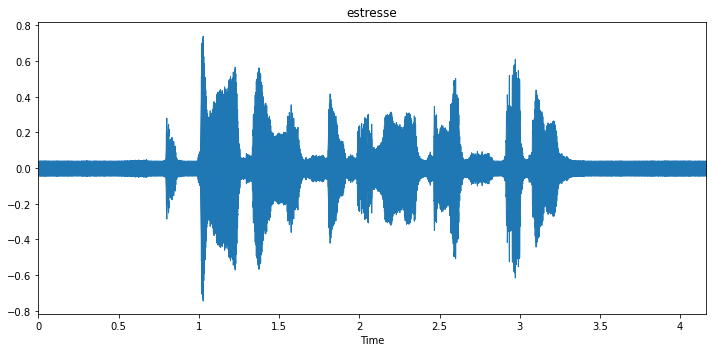

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10,5))

data, sample_rate = librosa.load(audio_samples[0], sr = None)
librosa.display.waveplot(data, sample_rate, ax=axs)
axs.set_title('{}'.format(labels[0]))

fig.tight_layout()

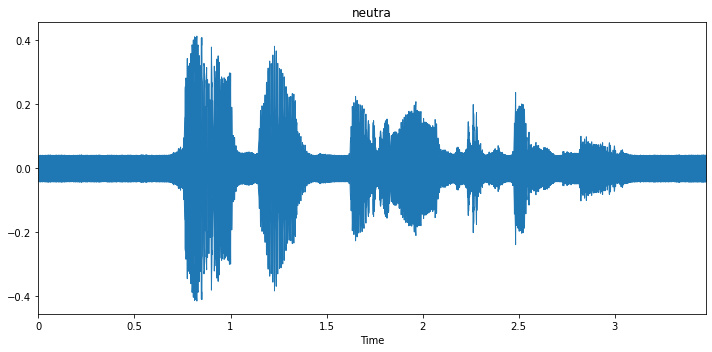

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10,5))

data, sample_rate = librosa.load(audio_samples[1], sr = None)
librosa.display.waveplot(data, sample_rate, ax=axs)
axs.set_title('{}'.format(labels[1]))

fig.tight_layout()

### Espectrogramas de MFCC's

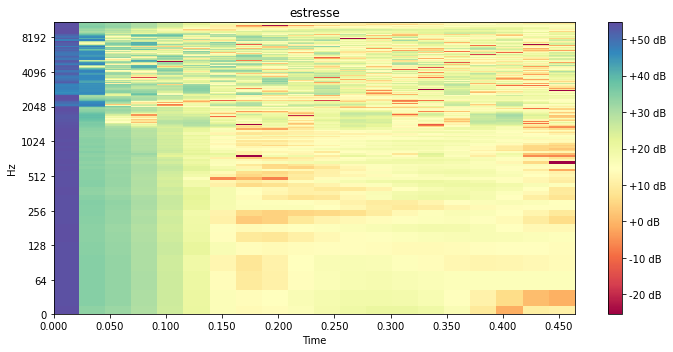

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10,5))

data, sample_rate = librosa.load(audio_samples[0], sr = None)
mfccs = librosa.feature.mfcc(y = data, sr=sample_rate, n_mfcc=20).T
mfccs_db = librosa.amplitude_to_db(np.abs(mfccs))
img = librosa.display.specshow(mfccs_db, x_axis="time", y_axis='log', ax=axs, cmap = 'Spectral')
axs.set_title('{}'.format(labels[0]))
fig.colorbar(img, ax=axs, format='%+2.f dB')

fig.tight_layout()

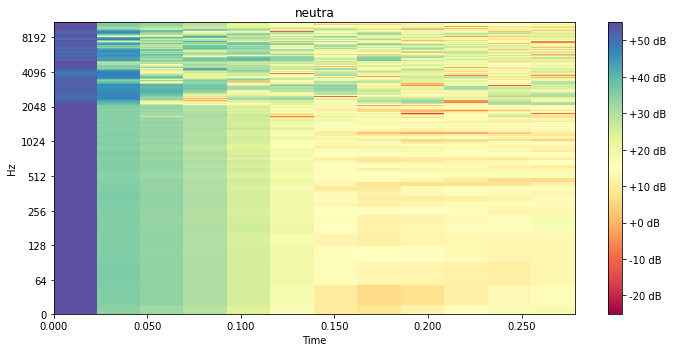

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10,5))

data, sample_rate = librosa.load(audio_samples[1], sr = None)
mfccs = librosa.feature.mfcc(y = data, sr=sample_rate, n_mfcc=12).T
mfccs_db = librosa.amplitude_to_db(np.abs(mfccs))
img = librosa.display.specshow(mfccs_db, x_axis="time", y_axis='log', ax=axs, cmap = 'Spectral')
axs.set_title('{}'.format(labels[1]))
fig.colorbar(img, ax=axs, format='%+2.f dB')

fig.tight_layout()

# Pré-processamento
### Extraindo recursos/características MFCC's de cada arquivo de áudio do dataset

In [ ]:
def extract_features(file_name):
    data, sample_rate = librosa.load(file_name, sr = None, res_type = 'kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y = data, sr = sample_rate, n_fft=2048, hop_length=512, n_mfcc = 12)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis = 0)
    return mfccs_scaled_features

extracted_features=[]
for path in tqdm(df.Caminho.values):
  data = extract_features(path)
  extracted_features.append([data])

100%|██████████| 3495/3495 [23:30<00:00,  2.48it/s]


 #sr = None para utilizar a taxa a amostragem padrão do proprio arquivo

  # n_mfcc pode variar para cada base de dados

In [ ]:
extracted_features_df = pd.DataFrame(extracted_features, columns = ['feature'])
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(df.Emocao.tolist())

In [ ]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [ ]:
# 20% teste e 80% treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_train.shape, X_test.shape

((2796, 12, 1), (699, 12, 1))

In [ ]:
num_labels = y.shape[1]
num_labels

2

### Criação da estrutura da rede neural

 * Parâmetros:
  * `Sequential`, é a classe para criar a rede neural, pois uma rede neural nada mais é que uma sequência de camadas (camada e entrada, camadas ocultas, camada de saída);  
  * `activation`, função de ativação;
  * `input_shape`, na primeira camada este é o tamanho dos dados de entrada
  * Camada `MaxPooling1D`, que vai fazer a extração das características principais;
  * Camada `LSTM`, uma rede neural recorrente que realiza o transporte dos dados durante um longo período de tempo;
  * Camada `Flatten`, para transformar de matriz em vetor;
  * Camada `Dense`, quando um neurônio de uma camada está ligado a todas os outros neurônios das outras camadas;
  * `Dropout`, é uma técnica para diminuir o overfitting;

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
input_shape

(12, 1)

In [ ]:
model=Sequential()

model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=input_shape))
model.add(LSTM(100, return_sequences=True, activation='relu'))
model.add(LSTM(100, return_sequences=True, activation='relu'))
model.add(LSTM(64, recurrent_dropout=0.3))
model.add(Dense(num_labels, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=optimiser)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 12, 100)           66000     
                                                                 
 lstm_2 (LSTM)               (None, 12, 100)           80400     
                                                                 
 lstm_3 (LSTM)               (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 205,666
Trainable params: 205,666
Non-trainable params: 0
_________________________________________________________________


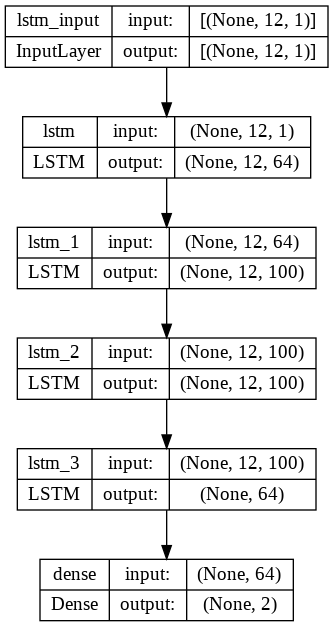

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

 # Treinando o modelo
 * `num_epochs`, número de épocas de treinamento
 * `num_batch_size`, isto indica que vamos enviar de 32 em 32 recursos de áudio (32, 64, 96, 128,...8732)

ModelCheckpoint, para salvar o modelo enquanto faz o treinamento
 * `filepath`, caminho onde será salvo o modelo. Para isto temos uma pasta no Drive chamada *saved_models*
 * `verbose`, mostrar mensagens enquanto a rede neural é treinada
 * `save_best_only = True`, para salvar o modelo somente quando houver uma melhora no resultado

`model_history` para armazenar o histórico de treinamento:
 * `model.fit` para fazer o ajuste do pesos ao longo do treinamento
  * `X_train`, `Y_train`, dados de treinamento
  * `batch_size = num_batch_size` definido acima
  * `epochs = num_epochs` definido acima
  * `validation_data=(X_test, Y_test)`, dados de teste para monitorarmos como está o percentual de acerto da rede neural a cada época
  * `callbacks=[checkpointer]`, checkpointer definido anteriormente
  * `verbose = 1`, para mostrar as mensagens

In [ ]:
num_epochs = 100
num_batch_size = 32

checkpointerRavdess = ModelCheckpoint(filepath='/content/saved_models/reconhecimento_emocao_ravdess.hdf5',
                               verbose=1, save_best_only=True)
checkpointerSavee = ModelCheckpoint(filepath='/content/saved_models/reconhecimento_emocao_savee.hdf5',
                               verbose=1, save_best_only=True)

model_history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
                          validation_data=(X_test, y_test), callbacks=[checkpointerSavee], verbose=1)

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.1495 - accuracy: 0.9424
Epoch 1: val_loss improved from inf to 0.14061, saving model to /content/saved_models/reconhecimento_emocao_savee.hdf5
6/6 [==============================] - 1s 144ms/step - loss: 0.1495 - accuracy: 0.9424 - val_loss: 0.1406 - val_accuracy: 0.9375
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.9319
Epoch 2: val_loss did not improve from 0.14061
6/6 [==============================] - 1s 110ms/step - loss: 0.1461 - accuracy: 0.9319 - val_loss: 0.1599 - val_accuracy: 0.9167
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.1382 - accuracy: 0.9372
Epoch 3: val_loss did not improve from 0.14061
6/6 [==============================] - 1s 112ms/step - loss: 0.1382 - accuracy: 0.9372 - val_loss: 0.1469 - val_accuracy: 0.9583
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.9476
Epoch 4: val_loss did not im

# Avaliação do modelo

In [ ]:
model.evaluate(X_test,y_test, verbose=0)

[0.2635566294193268, 0.9166666865348816]

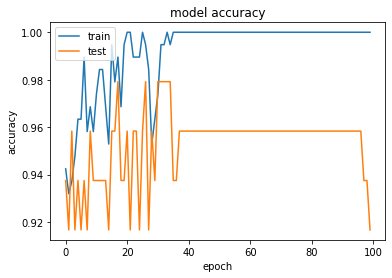

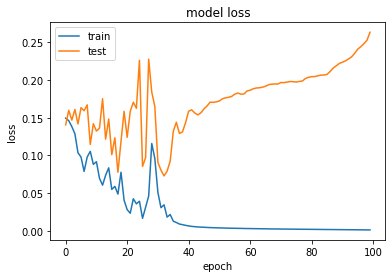

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test)
predictions = predictions.argmax(axis=1)
predictions

22/22 [==============================] - 0s 6ms/step


array([0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,

In [ ]:
predictions = predictions.astype(int).flatten()
predictions = (labelencoder.inverse_transform((predictions)))
predictions = pd.DataFrame({'Classes Previstas': predictions})
predictions

,Classes Previstas
0,estresse
1,neutra
2,estresse
3,neutra
4,neutra
...,...
694,neutra
695,neutra
696,estresse
697,estresse


In [ ]:
atual = y_test.argmax(axis=1)
atual = atual.astype(int).flatten()
atual = (labelencoder.inverse_transform((atual)))
atual = pd.DataFrame({'Classes Reais': atual})
atual

,Classes Reais
0,estresse
1,neutra
2,estresse
3,neutra
4,estresse
...,...
694,neutra
695,neutra
696,estresse
697,estresse


In [ ]:
finaldf = atual.join(predictions)
finaldf[0:20]

,Classes Reais,Classes Previstas
0,estresse,estresse
1,neutra,neutra
2,estresse,estresse
3,neutra,estresse
4,estresse,neutra
5,estresse,estresse
6,estresse,estresse
7,estresse,estresse
8,estresse,estresse
9,neutra,neutra


## Exibindo a Matriz de confusão

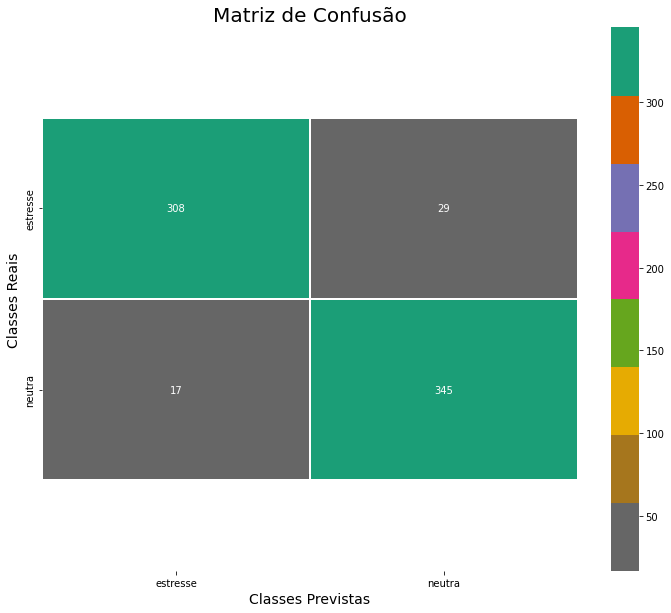

In [ ]:
cm = confusion_matrix(atual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in labelencoder.classes_] , columns = [i for i in labelencoder.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Dark2_r', linewidth=1, annot=True, fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Matriz de Confusão', size=20)
plt.xlabel('Classes Previstas', size=14)
plt.ylabel('Classes Reais', size=14)
plt.show()

In [ ]:
print(classification_report(atual, predictions))

              precision    recall  f1-score   support

    estresse       0.95      0.91      0.93       337
      neutra       0.92      0.95      0.94       362

    accuracy                           0.93       699
   macro avg       0.94      0.93      0.93       699
weighted avg       0.93      0.93      0.93       699

